<h1>EpiScanpy tutorial</h1><br>
In this tutorial we will explore a dataset of <strong>mouse brain</strong>. The data was produced by <strong>10x genomics</strong>. It comprises around <strong>3000 cells</strong>.<br><br><br>
We will follow a typical workflow with steps including:
<ul>
    <li>Creating a count matrix</li>
    <li>Adding metadata</li>
    <li>Quality control</li>
    <li>Create an embedding</li>
    <li>Clustering</li>
    <li>Marker identification</li>
    <li>Visualization</li>
</ul>

In [ ]:
#[1] * 9 ** 10

<br><hr><br><br><h3>Import your packages</h3>

In [ ]:
!pip install episcanpy leidenalg scanpy episcanpy anndata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

import scanpy as sc
import episcanpy as epi
import anndata as ad

import matplotlib.pyplot as plt

import time
import pickle
import os

In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
file_path = "/content/drive/My Drive/"

Mounted at /content/drive/


In [ ]:
os.listdir(file_path) # shows all files in file_path

['Colab Notebooks',
 'Datasets',
 'Геймесы.gsheet',
 '3k_PBMC',
 'day1_beginner',
 'Presentations',
 'scanpy_tutorial',
 'episcanpy_tutorial',
 'Other',
 'Christmas Party Drawful .gform',
 'Christmas Party Drawful  (Responses).gsheet',
 'image.jpg']

<br><h3>Setting some initial variables</h3>

In [ ]:
name = "5k_brain"

base_dir = "{}episcanpy_tutorial/".format(file_path)

peak_file = base_dir + "{}_peaks.narrowPeak".format(name)
fragments_file = base_dir + "atac_v1_adult_brain_fresh_5k_fragments.tsv.gz"

gtf_file = base_dir + "gencode.vM25.basic.annotation.gtf.gz"

<br><h3>Load and filter barcode information</h3>

In [ ]:
barcode_info = pd.read_csv(base_dir + "atac_v1_adult_brain_fresh_5k_singlecell.csv")
print(barcode_info.is__cell_barcode.value_counts())

0    495824
1      3880
Name: is__cell_barcode, dtype: int64


In [ ]:
valid_barcodes = barcode_info[barcode_info.is__cell_barcode == 1].barcode.tolist()
valid_barcodes[:5]

['AAACGAAAGTAATCAG-1',
 'AAACGAACACGCTGTG-1',
 'AAACGAATCCTGGGAC-1',
 'AAACGAATCGGGAAAC-1',
 'AAACTCGAGAAAGCAG-1']

<br><h3>Load and add annotation</h3>

In [ ]:
anno = ad.read(base_dir + "10x-ATAC-Brain5k.h5ad")
anno

AnnData object with n_obs × n_vars = 2317 × 155093
    obs: 'cell_type', 'domain', 'protocol', 'dataset'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'

In [ ]:
anno_per_bc = {bc: anno for bc, anno in zip(anno.obs.index, anno.obs.cell_type)}

<br><hr><br><br><h3>Compute the (peak) matrix</h3>

In [ ]:
# adata = epi.ct.window_mtx(
#     fragments_file,
#     valid_barcodes,
#     window_size=100000,
#     species="human",
#     fast=True
# )

# adata

In [ ]:
# adata = epi.ct.gene_activity_mtx(
#     fragments_file,
#     gtf_file,
#     valid_barcodes,
#     upstream=2000,
#     downstream=0,
#     source="HAVANA",
#     gene_type=["protein_coding"],
#     fast=True
# )

# adata

In [ ]:
adata = epi.ct.peak_mtx(
    fragments_file,
    peak_file, 
    valid_barcodes,
    normalized_peak_size=None,
    fast=False
)

adata

AnnData object with n_obs × n_vars = 3880 × 189587
    var: 'chr', 'start', 'stop'

In [ ]:
?epi.ct.peak_mtx

In [ ]:
adata.obs["cell_type"] = [anno_per_bc[bc] if bc in anno_per_bc else "No Annotation" for bc in adata.obs.index.tolist()]
adata.obs

,cell_type
AAACGAAAGTAATCAG-1,L5 IT
AAACGAACACGCTGTG-1,L2/3 IT
AAACGAATCCTGGGAC-1,L6 IT
AAACGAATCGGGAAAC-1,No Annotation
AAACTCGAGAAAGCAG-1,L2/3 IT
...,...
TTTGTGTGTACTTCAG-1,L4
TTTGTGTGTCATAAGA-1,L2/3 IT
TTTGTGTTCAGGGTTT-1,L6 CT
TTTGTGTTCTCTGCGT-1,L5 IT


<br><hr><br><br><h3>Binarize the matrix and compute QC metrics</h3>

In [ ]:
print("Max before:\t{}".format(np.max(adata.X)))
epi.pp.binarize(adata)
print("Max after:\t{}".format(np.max(adata.X)))

Max before:	20.0
Max after:	1.0


In [ ]:
epi.pp.qc_stats(adata, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features to .obs


In [ ]:
epi.pp.nucleosome_signal(adata, fragments_file, n=10000)

In [ ]:
epi.pp.tss_enrichment(adata, gtf=gtf_file, fragments=fragments_file, n=5000, score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100)

In [ ]:
# The lazy_qc function runs qc_stats, nucleosome_signal, and tss_enrichment with default parameters.

# epi.pp.lazy_qc(adata, fragments=fragments_file, gtf=gtf_file)

<br><hr><br><br><h3>QC visualization + determine filtering thresholds</h3>

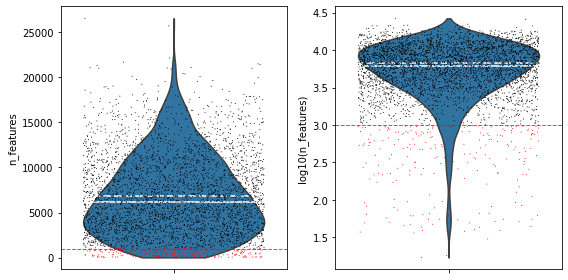

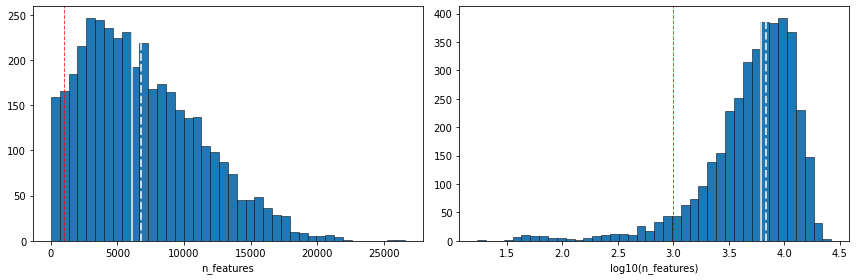

Max:	26571
Median:	6124.5
Mean:	6804.136340206185
Min:	17


In [ ]:
min_features = 1000
max_features = None

epi.pl.violin(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

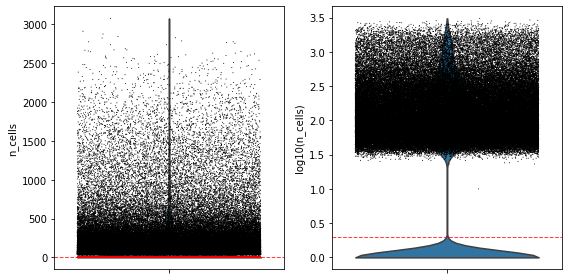

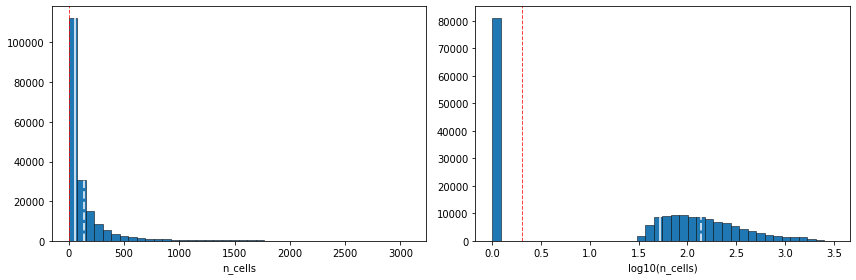

Max:	3079
Median:	52.0
Mean:	139.25031252142816
Min:	0


In [ ]:
min_cells = 2
max_cells = None

epi.pl.violin(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

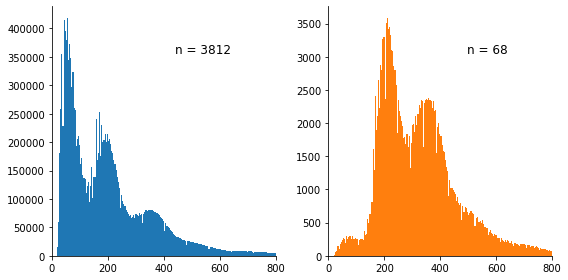

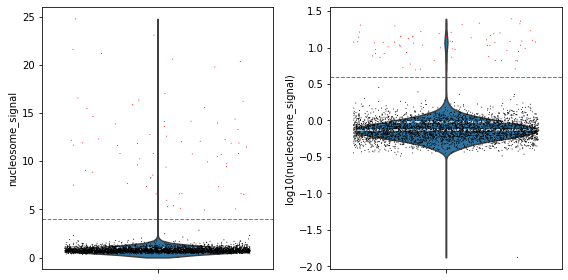

Max:	24.763636363636362
Median:	0.7455087446527191
Mean:	0.9676022149952296
Min:	0.013245033112582781


In [ ]:
max_nucleosome_signal = 4

epi.pl.fragment_length(adata, n=5000, threshold=max_nucleosome_signal, show_n=True)
epi.pl.violin(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

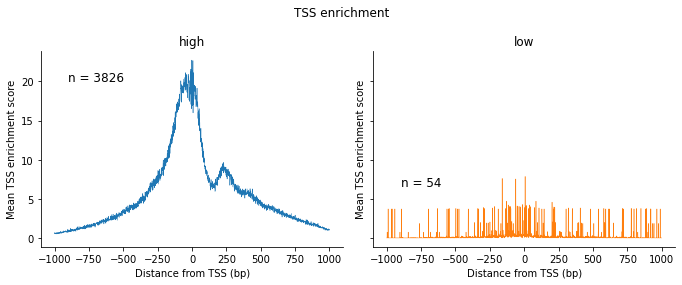

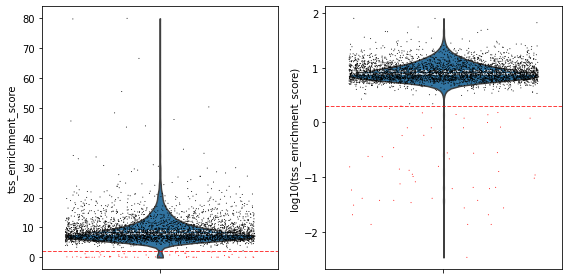

Max:	79.92007992007991
Median:	7.797021572531776
Mean:	8.879653820375259
Min:	0.0


In [ ]:
min_tss_enrichment = 2

adata.obs["tss"] = ["high" if val > min_tss_enrichment else "low" for val in adata.obs.tss_enrichment_score]

epi.pl.tss_enrichment(adata, group_by="tss", show_n=True)
epi.pl.violin(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

<br><hr><br><br><h3>Set, check, and apply filters</h3>

In [ ]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features)
epi.pp.set_filter(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal)
epi.pp.set_filter(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment)

epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells)

3633 of 3880 observations remain (-247)
3812 of 3880 observations remain (-68)
3826 of 3880 observations remain (-54)
108390 of 189587 features remain (-81197)


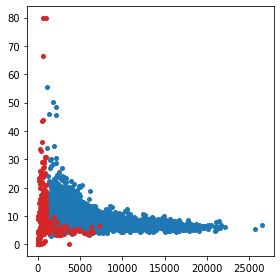

In [ ]:
epi.pl.show_filters(adata, x="n_features", y="tss_enrichment_score", save=None)

In [ ]:
adata = epi.pp.apply_filters(adata, verbose=True)

3577 of 3880 observations remain (-303)
108390 of 189587 features remain (-81197)


<br><hr><br><br><h3>Select highly variable features</h3>

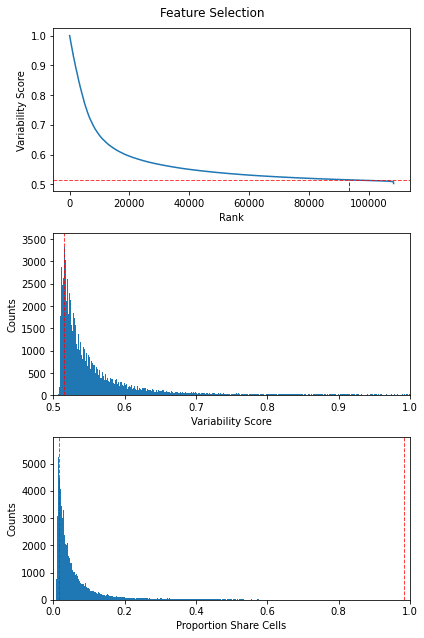

In [ ]:
epi.pp.highly_variable(adata, min_score=0.515, n_features=None)

In [ ]:
adata = epi.pp.select_highly_variable(adata, verbose=True)

93556 of 108390 features remain (-14834)


<br><hr><br><br><h3>Normalization and log-transformation</h3>

In [ ]:
epi.pp.normalize_total(adata)
epi.pp.log1p(adata)

<br><hr><br><br><h3>Principal component analysis, neighborhood graph, UMAP, and visualization</h3>

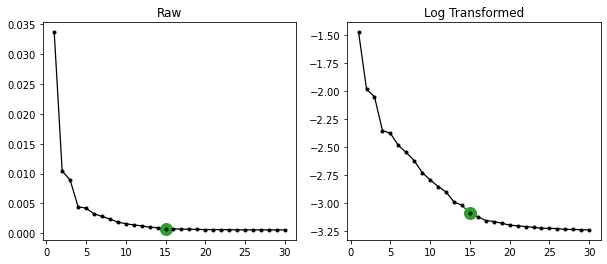

In [ ]:
epi.pp.pca(adata, n_comps=30)
n_comps = epi.pp.find_elbow(adata, use_log=True, show_anno=False)

In [ ]:
epi.pp.neighbors(adata, n_pcs=n_comps, method="umap")

In [ ]:
epi.tl.umap(adata)

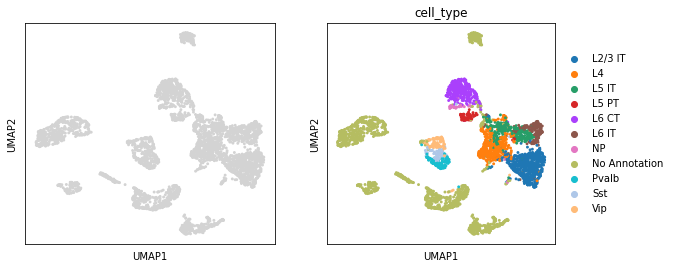

In [ ]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(adata, color=[None, "cell_type"])

<br>Let's try again with a higher number of components

In [ ]:
epi.pp.neighbors(adata, n_pcs=22, method="umap")

In [ ]:
epi.tl.umap(adata)

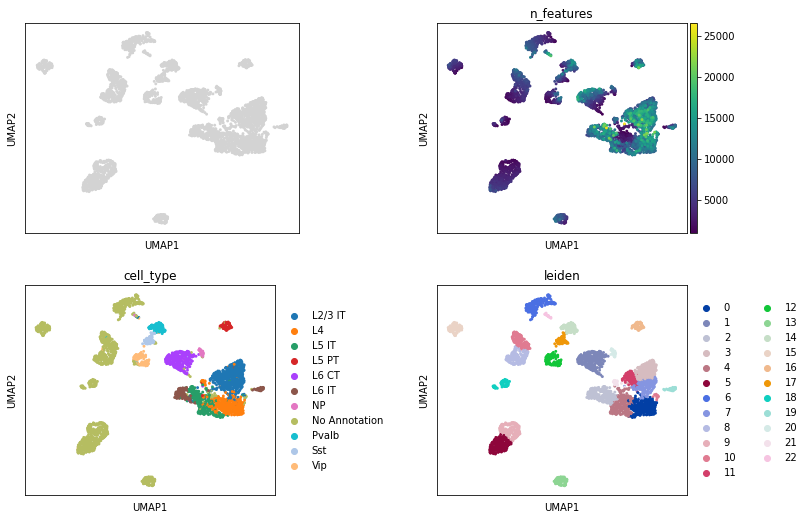

In [ ]:
epi.tl.leiden(adata, resolution=1.2)
epi.pl.umap(adata, color=[None, "n_features", "cell_type", "leiden"], ncols=2, wspace=0.5)

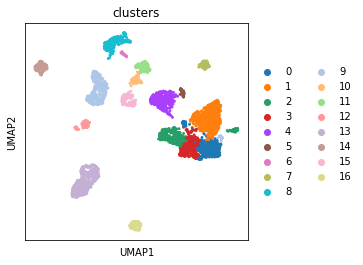

In [ ]:
new_clusters = [[0, 21], [7, 11, 3], [2, 19], [4], [1], [20], [22], [16], [6], [8, 10], [17], [14], [18], [5, 9], [15], [12], [13]]
new_clusters = {str(old): str(new) for new, olds in enumerate(new_clusters) for old in olds}

adata.obs["clusters"] = [new_clusters[old_cluster] for old_cluster in adata.obs.leiden]
epi.pl.umap(adata, color=["clusters"])

<br><hr><br><br><h3>Marker identification</h3>

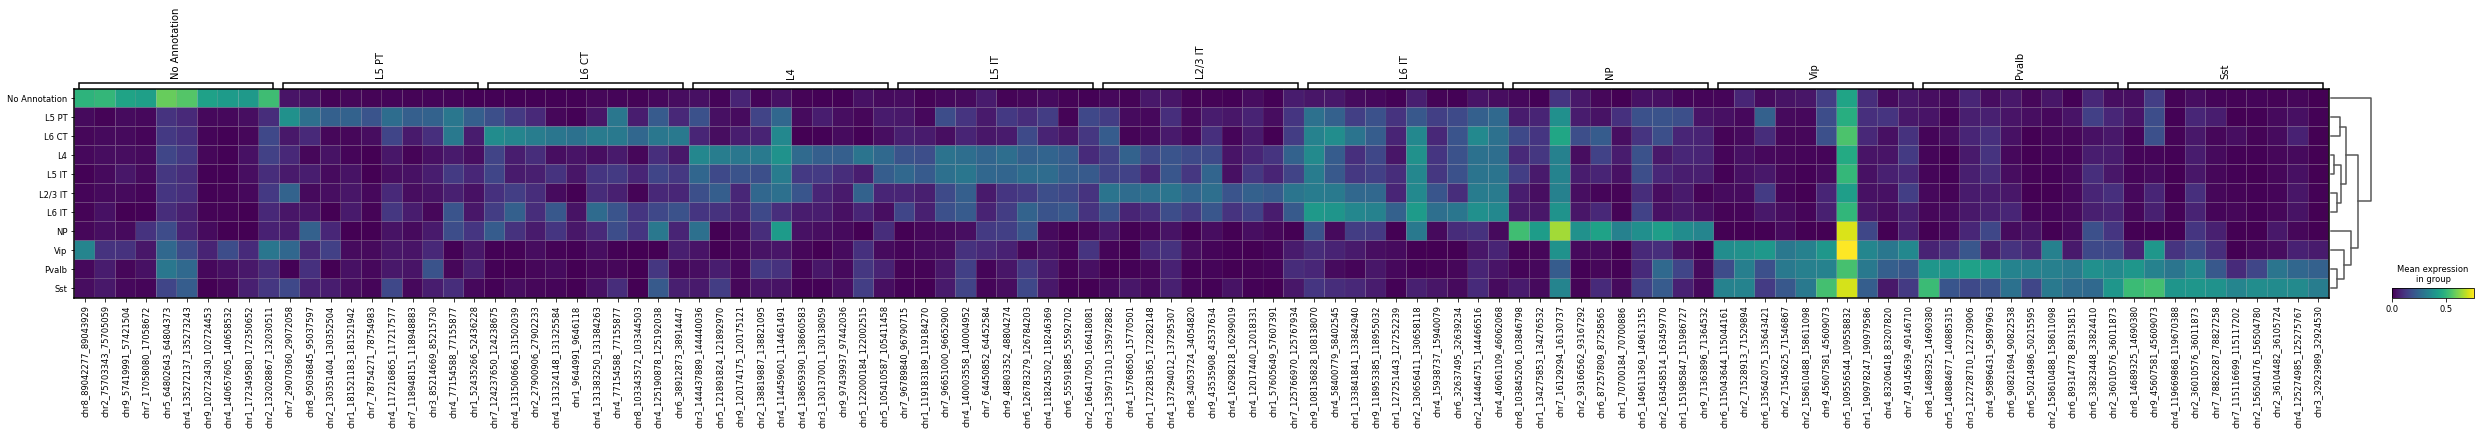

In [ ]:
epi.tl.rank_features(adata, groupby="cell_type", use_raw=False, omic="ATAC")
epi.pl.rank_feat_groups_matrixplot(adata)

In [ ]:
groups = [group for group in adata.obs.cell_type.cat.categories]

new_markers = {group: adata.uns["rank_features_groups"]["names"][group].tolist()[:8] for group in groups}

for cell_type, markers in new_markers.items():
    print(cell_type)
    epi.pl.umap(adata, color=markers)

<br><hr><br><br><h3>Compute the gene activity matrix</h3>

In [ ]:
gene_activity = epi.ct.gene_activity_mtx(
    fragments_file,
    gtf_file,
    valid_barcodes,
    upstream=2000,
    downstream=0,
    source="HAVANA",
    gene_type=["protein_coding"],
    fast=False
)

gene_activity

AnnData object with n_obs × n_vars = 3880 × 21673
    var: 'gene_name', 'gene_id', 'gene_type', 'chr', 'start', 'stop', 'strand', 'source'

In [ ]:
gene_activity = gene_activity[adata.obs.index.tolist()].copy()

In [ ]:
gene_activity.obs["cell_type"] = adata.obs.cell_type
gene_activity.obs["clusters"] = adata.obs.clusters

In [ ]:
gene_activity.var.index = gene_activity.var.gene_name
gene_activity.var_names_make_unique()

<br><hr><br><br><h3>Normalization and log-transformation</h3>

In [ ]:
epi.pp.normalize_total(gene_activity)
gene_activity.layers["normalized"] = gene_activity.X.copy()
epi.pp.log1p(gene_activity)

<br><hr><br><br><h3>Select highly variable features</h3>

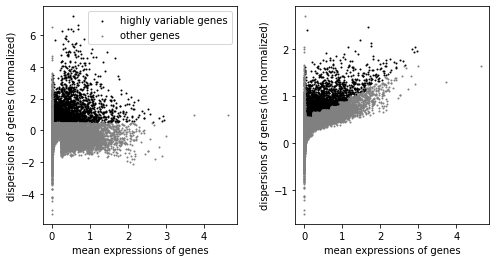

In [ ]:
sc.pp.highly_variable_genes(gene_activity)
sc.pl.highly_variable_genes(gene_activity)

<br><hr><br><br><h3>Principal component analysis, neighborhood graph, UMAP, and visualization</h3>

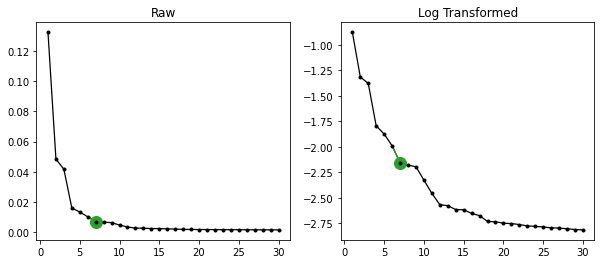

In [ ]:
epi.pp.pca(gene_activity, n_comps=30, use_highly_variable=True)
n_comps = epi.pp.find_elbow(gene_activity, use_log=True)

In [ ]:
epi.pp.neighbors(gene_activity, n_neighbors=15, n_pcs=n_comps, method="umap")
epi.tl.umap(gene_activity)

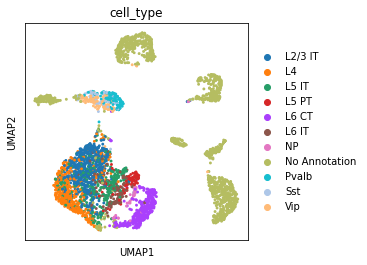

In [ ]:
plt.rcParams["figure.figsize"]= (4, 4)
epi.pl.umap(gene_activity, color=["cell_type"])

<br><hr><br><br><h3>Transfer peak embedding to gene activity AnnData object</h3>

In [ ]:
gene_activity.obsm["X_umap"] = adata.obsm["X_umap"]

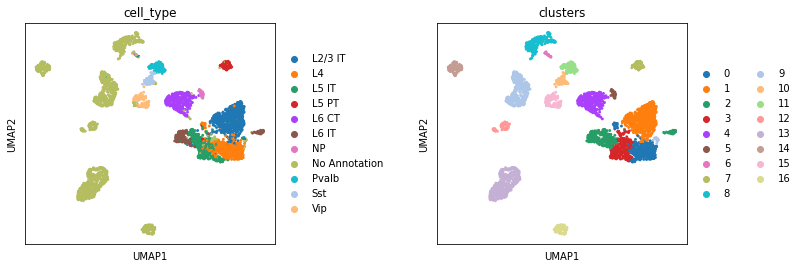

In [ ]:
epi.pl.umap(gene_activity, color=["cell_type", "clusters"], wspace=0.5)

<br><hr><br><br><h3>Markers</h3>

Neuron


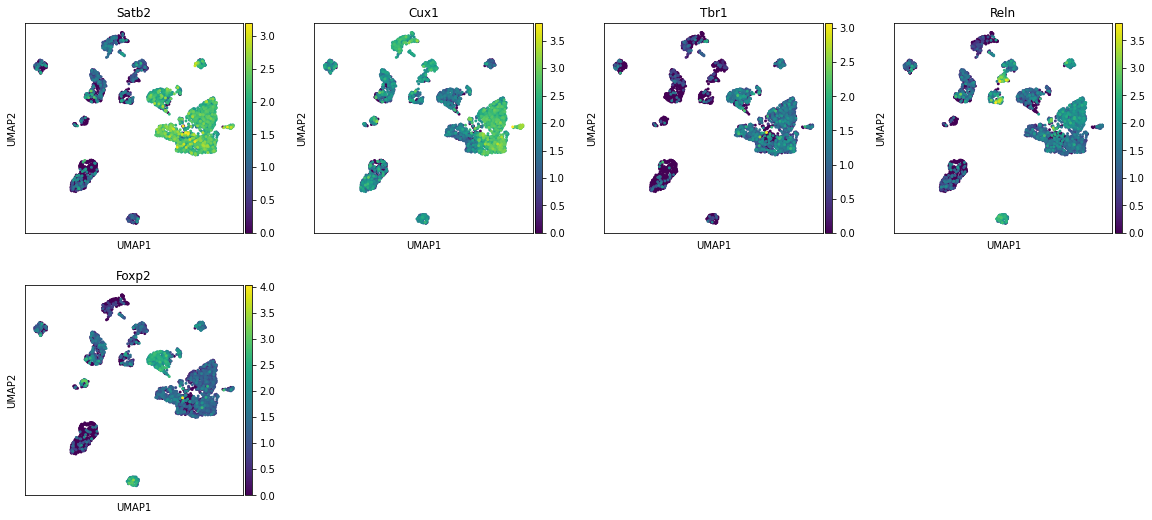

Immature


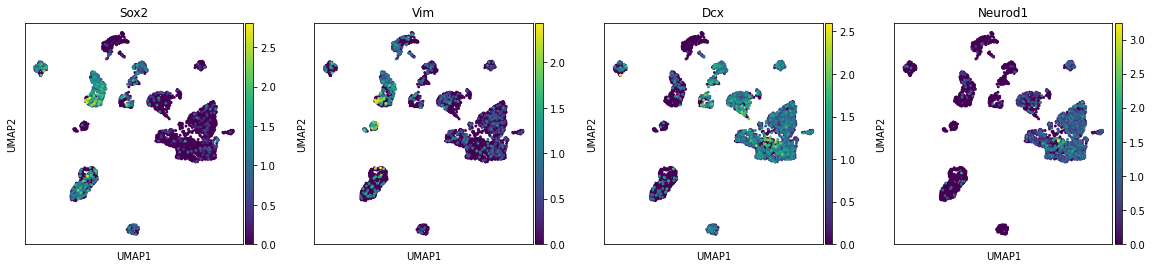

Microglia


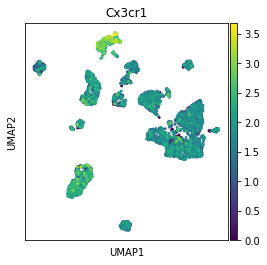

Mature Oligo


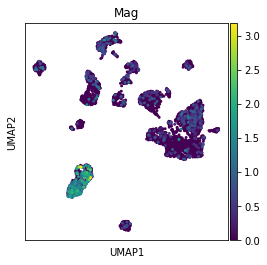

Pro-myelinating oligo


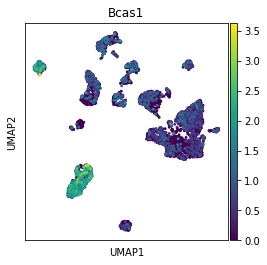

OPCs


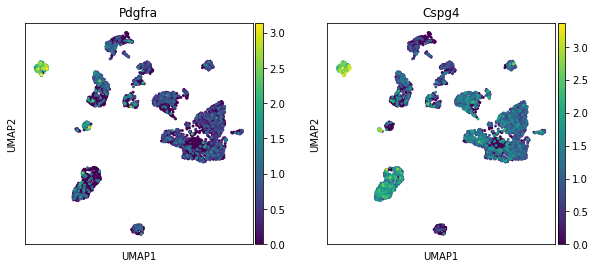

Astrocytes


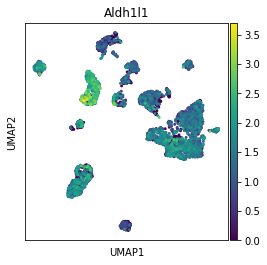

Endo


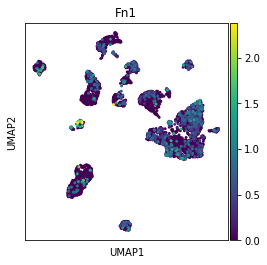

In [ ]:
marker_genes_dict = {
    'Neuron':  ['Rbfox3', 'Satb2', 'Cux1','Tbr1',"Reln","Fezf2","Foxp2", 'Pvalb','Sst'],
    'Immature': ["Sox2", "Vim","Dcx","Tubb3","Neurod1", "Ascl1"],
    'Microglia': ['P2ry12','Cx3cr1'],
    'Mature Oligo': ['Olig1','Olig2', 'Mbp', 'Mog','Mag','Cnp','Sox10'],
    'Pro-myelinating oligo': ['Bcas1'],
    'OPCs': ['Pdgfra', 'Cspg4'],
    'Astrocytes': ['Gfap', 'Aldh1l1','S100b','Sox9','Aqp4'],
    'Endo': ['Fn1', 'Cldn5'],
}

for cell_type, markers in marker_genes_dict.items():
    print(cell_type)
    markers = [marker for marker in markers if gene_activity[:, marker].X.sum() > 0]
    epi.pl.umap(gene_activity, color=markers)

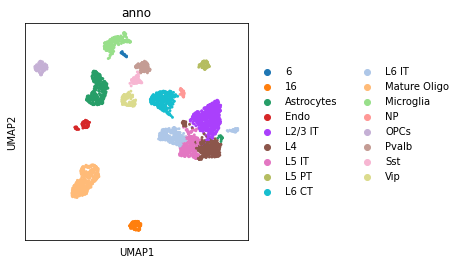

In [ ]:
anno_per_cluster = {"0": "L4", 
 "1": "L2/3 IT",
 "2": "L6 IT",
 "3": "L5 IT",
 "4": "L6 CT",
 "5": "NP",
 "6": "6",
 "7": "L5 PT",
 "8": "Microglia",
 "9": "Astrocytes",
 "10": "Sst",
 "11": "Pvalb",
 "12": "Endo",
 "13": "Mature Oligo",
 "14": "OPCs",
 "15": "Vip",
 "16": "16"}

gene_activity.obs["anno"] = [anno_per_cluster[cluster] for cluster in gene_activity.obs.clusters]
epi.pl.umap(gene_activity, color=["anno"])

<br><hr><br><br><h3>Marker identification</h3>

In [ ]:
sc.tl.rank_genes_groups(gene_activity, "anno")

In [ ]:
groups = [group for group in gene_activity.obs.anno.cat.categories]
new_markers = {group: gene_activity.uns["rank_genes_groups"]["names"][group].tolist()[:8] for group in groups}

In [ ]:
plt.rcParams["figure.figsize"]= (18, 3)
epi.pl.rank_feat_groups_violin(gene_activity, key="rank_genes_groups")

In [ ]:
plt.rcParams["figure.figsize"]= (4, 4)

for cell_type, markers in new_markers.items():
    print(cell_type)
    epi.pl.umap(gene_activity, color=markers)

In [ ]:
for cell_type, markers in new_markers.items():
    print(cell_type)
    epi.pl.umap(gene_activity, color=markers, layer="normalized", vmax="p99.9")